In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
import scipy.special
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
g = sp.constants.g
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

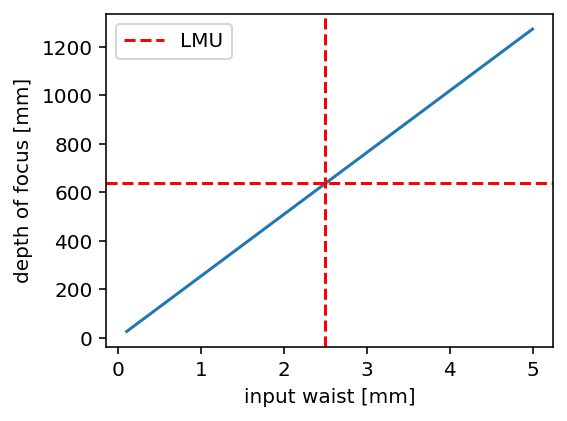

In [14]:
n = 1.45
alpha = 0.5/180*np.pi
beta = np.arcsin(n*np.sin(alpha))
gamma = np.pi/2-beta+alpha

a = np.linspace(0.1e-3, 5e-3, 100)

def L(a, alpha):
    beta = np.arcsin(n*np.sin(alpha))
    gamma = np.pi/2-beta+alpha
    return a*np.tan(gamma)-a*np.tan(alpha)


La = L(a, alpha)

plt.figure(figsize=(4,3), dpi=144)
plt.plot(a*1e3, La*1e3)
plt.xlabel('input waist [mm]')
plt.ylabel('depth of focus [mm]')
plt.axvline(2.5, c='r', linestyle='--', label='LMU')
plt.axhline(L(2.5e-3, alpha)*1e3, c='r', linestyle='--')
plt.legend()

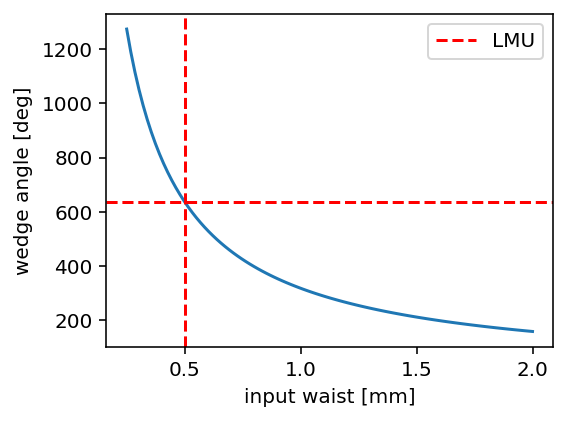

In [12]:
n = 1.45
a = 2.5e-3

alpha = np.linspace(0.25/180*np.pi, 2/180*np.pi, 100)

def L(a, alpha):
    beta = np.arcsin(n*np.sin(alpha))
    gamma = np.pi/2-beta+alpha
    return a*np.tan(gamma)-a*np.tan(alpha)


Lalpha = L(a, alpha)

plt.figure(figsize=(4,3), dpi=144)
plt.plot(alpha/np.pi*180, Lalpha*1e3)
plt.xlabel('input waist [mm]')
plt.ylabel('wedge angle [deg]')
plt.axvline(0.5, c='r', linestyle='--', label='LMU')
plt.axhline(L(a, 0.5/180*np.pi)*1e3, c='r', linestyle='--')
plt.legend()

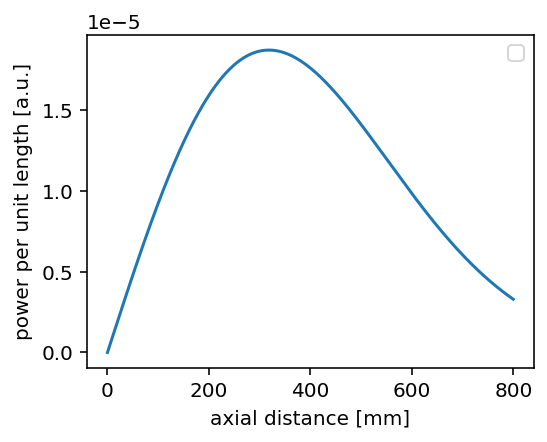

In [24]:
def I_axial(z):
    n = 1.45
    alpha = 0.5/180*np.pi
    beta = np.arcsin(n*np.sin(alpha))
    gamma = np.pi/2-beta+alpha
    w0=2.5e-3
    
    return (2*np.pi*np.cos(beta-alpha)*z
            *np.exp(-2*z**2/w0**2/(np.tan(gamma)-np.tan(alpha))**2)
            /(np.tan(gamma)-np.tan(alpha))**2 )

z = np.linspace(0, 800e-3, 1000)
I = I_axial(z)

plt.figure(figsize=(4,3), dpi=144)
plt.plot(z*1e3, I)
plt.xlabel('axial distance [mm]')
plt.ylabel('power per unit length [a.u.]')
#plt.axhline((2.5e-3/80e-6)**2, c='r', linestyle='--', label='80 um Gaussian peak')
plt.legend()

In [2]:
def I_total(rho, z, n, alpha, w0, P, _lambda):

    k = 2*np.pi/_lambda
    
    return 2*P/np.pi/w0**2 * (2*np.pi*k*(n-1)**2*alpha**2*z
            *np.exp(-2*z**2*(1-n)**2*alpha**2/w0**2) * sp.special.jv(0,(n-1)*k*rho*alpha)**2 
    )

In [10]:
def I_total2(rho, z, n, tau, w0, P, _lambda):

    alpha0 = np.arcsin(n*np.cos(tau/2)) + (tau-np.pi)/2

    zmax = w0/np.tan(alpha0)
    k = 2*np.pi/_lambda
    
    return (4*P*k*np.sin(alpha0)/w0*z/zmax*sp.special.jv(0,k*rho*np.sin(alpha0))**2 
            *np.exp(-2*z**2/zmax**2) 
    )

[[0.31791792]]


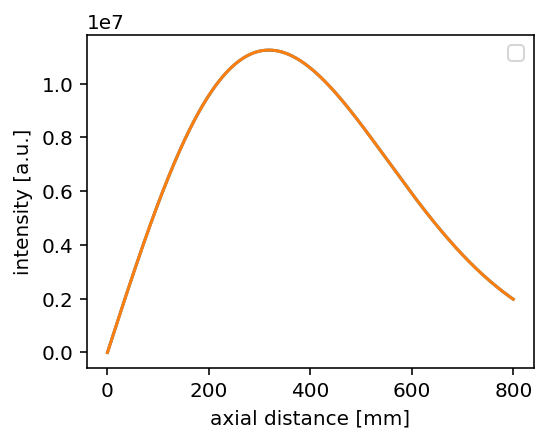

In [11]:
rho = 0
z = np.linspace(0, 800e-3, 1000)
n = 1.45
_lambda = 1064e-9
w0 = 2.5e-3
P = 1
alpha = 0.5/180*np.pi
tau = 179/180*np.pi

I =  I_total(rho, z, n, alpha, w0, P, _lambda)
I2 = I_total2(rho, z, n, tau, w0, P, _lambda)

plt.figure(figsize=(4,3), dpi=144)
plt.plot(z*1e3, I)
plt.plot(z*1e3, I2)
plt.xlabel('axial distance [mm]')
plt.ylabel('intensity [a.u.]')
#plt.axhline((2.5e-3/80e-6)**2, c='r', linestyle='--', label='80 um Gaussian peak')
plt.legend()

zmax = z[np.argwhere(I==max(I))]
print(zmax)

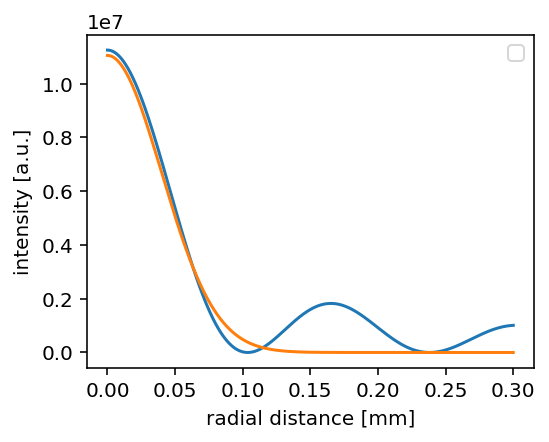

In [12]:
z = 0.318
rho = np.linspace(0, 0.3e-3, 1000)
n = 1.45
_lambda = 1064e-9
w0 = 2.5e-3
P = 1
alpha = 0.5/180*np.pi
tau = 179/180*np.pi

I =I_total(rho, z, n, alpha, w0, P, _lambda)

w0 = 2.5e-3
wG = 80e-6
IG = 2*P/np.pi/wG**2*np.exp(-2*rho**2/wG**2)

plt.figure(figsize=(4,3), dpi=144)
plt.plot(rho*1e3, I)
plt.plot(rho*1e3, IG/9)
plt.xlabel('radial distance [mm]')
plt.ylabel('intensity [a.u.]')
#plt.axhline((2.5e-3/80e-6)**2, c='r', linestyle='--', label='80 um Gaussian peak')
plt.legend()


6.763857715440563


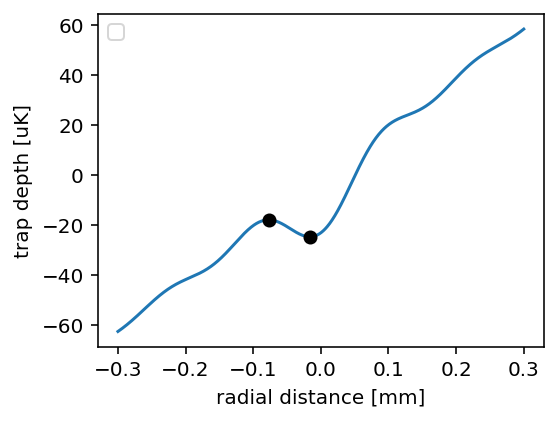

In [3]:
rho = np.linspace(-0.3e-3, 0.3e-3, 1000)

z = 0.25

n = 1.45
_lambda = 1035e-9
w0 = 1.5e-3
P = 10
alpha = 0.5/180*np.pi
tau = 179/180*np.pi

I =  4*I_total(rho, z, n, alpha, w0, P, _lambda)

pol = 145*a_au

U = -1/epsilon0/c/2*pol*I + 171*u*g*rho

dips = np.where((U[1:-1] < U[0:-2]) * (U[1:-1] < U[2:]))[0] + 1
peaks = np.where((U[1:-1] > U[0:-2]) * (U[1:-1] > U[2:]))[0] + 1

plt.figure(figsize=(4,3), dpi=144)
plt.plot(rho*1e3, U/kB*1e6)
plt.plot (rho[dips]*1e3, U[dips]/kB*1e6, 'ko')
plt.plot (rho[peaks]*1e3, U[peaks]/kB*1e6, 'ko')
plt.xlabel('radial distance [mm]')
plt.ylabel('trap depth [uK]')
#plt.axhline((2.5e-3/80e-6)**2, c='r', linestyle='--', label='80 um Gaussian peak')
plt.legend()

print(max(U[peaks]-U[dips])/kB*1e6)


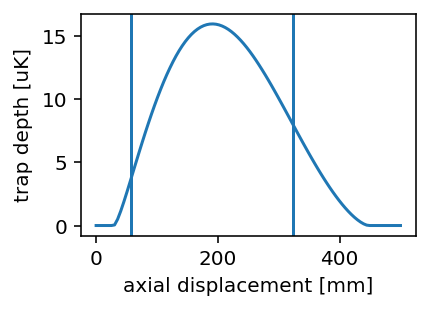

In [11]:
z_ls = np.linspace(0, 500e-3, 100)
depth = []

for z in z_ls:
    rho = np.linspace(-0.3e-3, 0.3e-3, 1000)

    n = 1.45
    _lambda = 1035e-9
    w0 = 3e-3
    P = 10
    alpha = 1/180*np.pi
    tau = 179/180*np.pi
    
    beta = np.arcsin(n*np.sin(alpha))
    gamma = np.pi/2-beta+alpha


    def L(a, alpha):
        beta = np.arcsin(n*np.sin(alpha))
        gamma = np.pi/2-beta+alpha
        return a*np.tan(gamma)-a*np.tan(alpha)


    zmax = L(w0, alpha)
    

    I =  4*I_total(rho, z, n, alpha, w0, P, _lambda)
    
    pol = 145*a_au

    U = -1/epsilon0/c/2*pol*I + 171*u*g*rho

    dips = np.where((U[1:-1] < U[0:-2]) * (U[1:-1] < U[2:]))[0] + 1
    peaks = np.where((U[1:-1] > U[0:-2]) * (U[1:-1] > U[2:]))[0] + 1

    if dips.size>0 and peaks.size>0:

            depth.append(max(U[peaks]-U[dips])/kB*1e6)
    else:
        depth.append(0)

plt.figure(figsize=(3, 2), dpi=144)
plt.plot(z_ls*1e3, depth)
plt.xlabel('axial displacement [mm]')
plt.ylabel('trap depth [uK]')
plt.axvline(zmax*1e3/2-133)
plt.axvline(zmax*1e3/2+133)

2.883690281253293


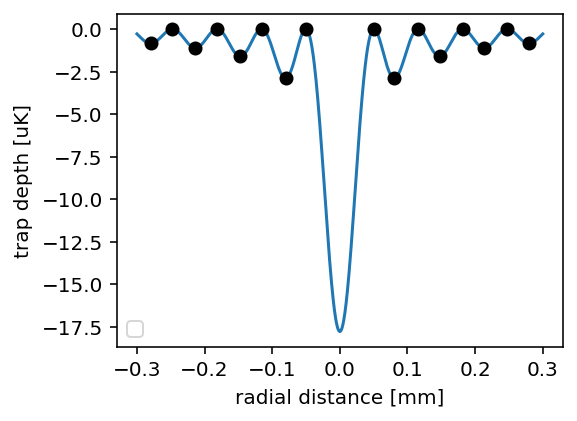

In [12]:
rho = np.linspace(-0.3e-3, 0.3e-3, 1000)

z = 0.25

n = 1.45
_lambda = 518e-9
w0 = 1.5e-3
P = 2
alpha = 0.5/180*np.pi
tau = 179/180*np.pi

I =  4*I_total(rho, z, n, alpha, w0, P, _lambda)

pol = 280*a_au

U = -1/epsilon0/c/2*pol*I #+ 171*u*g*rho

dips = np.where((U[1:-1] < U[0:-2]) * (U[1:-1] < U[2:]))[0] + 1
peaks = np.where((U[1:-1] > U[0:-2]) * (U[1:-1] > U[2:]))[0] + 1

plt.figure(figsize=(4,3), dpi=144)
plt.plot(rho*1e3, U/kB*1e6)
plt.plot (rho[dips]*1e3, U[dips]/kB*1e6, 'ko')
plt.plot (rho[peaks]*1e3, U[peaks]/kB*1e6, 'ko')
plt.xlabel('radial distance [mm]')
plt.ylabel('trap depth [uK]')
#plt.axhline((2.5e-3/80e-6)**2, c='r', linestyle='--', label='80 um Gaussian peak')
plt.legend()

print(max(U[peaks]-U[dips])/kB*1e6)


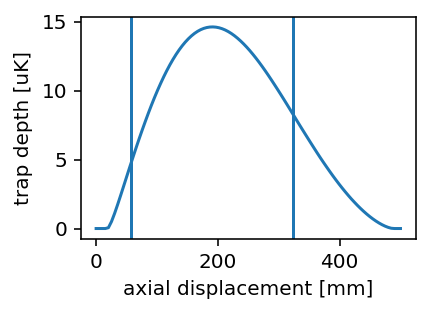

In [10]:
z_ls = np.linspace(0, 500e-3, 100)
depth = []

for z in z_ls:
    rho = np.linspace(-0.3e-3, 0.3e-3, 1000)

    n = 1.45
    _lambda = 518e-9
    w0 = 3e-3
    P = 2
    alpha = 1/180*np.pi
    
    beta = np.arcsin(n*np.sin(alpha))
    gamma = np.pi/2-beta+alpha


    def L(a, alpha):
        beta = np.arcsin(n*np.sin(alpha))
        gamma = np.pi/2-beta+alpha
        return a*np.tan(gamma)-a*np.tan(alpha)


    zmax = L(w0, alpha)
    

    I =  4*I_total(rho, z, n, alpha, w0, P, _lambda)
    
    pol = 280*a_au

    U = -1/epsilon0/c/2*pol*I + 171*u*g*rho

    dips = np.where((U[1:-1] < U[0:-2]) * (U[1:-1] < U[2:]))[0] + 1
    peaks = np.where((U[1:-1] > U[0:-2]) * (U[1:-1] > U[2:]))[0] + 1

    if dips.size>0 and peaks.size>0:

            depth.append(max(U[peaks]-U[dips])/kB*1e6)
    else:
        depth.append(0)

plt.figure(figsize=(3, 2), dpi=144)
plt.plot(z_ls*1e3, depth)
plt.xlabel('axial displacement [mm]')
plt.ylabel('trap depth [uK]')
plt.axvline(zmax*1e3/2-133)
plt.axvline(zmax*1e3/2+133)